# Getting the Data for a Long Island Rail Road Transit Flow Animation

This notebook will walk through downloading, cleaning and wrangling transit schedule data from Mapzen's [Transitland API](https://transit.land/) so that we can visualize it using Processing. Transitland ingests [General Transit Feed Specificaiton (GTFS)](https://en.wikipedia.org/wiki/General_Transit_Feed_Specification) data from transit operators around the world, processes and validates it, and serves it up with an open-source, free API.

### Inputs

Sign up for a [Mapzen API key](https://mapzen.com/developers/sign_up) if you don't already have one.

In [1]:
date = "2017-07-17"
mapzen_api_key = "mapzen-ai1duha"
directory = r"lirr" # determines how to name the output csv file

Get the onestop id for the LIRR on Transitland: https://transit.land/feed-registry/operators/o-dr5-longislandrailroad

In [2]:
operator_onestop_id = "o-dr5-longislandrailroad"

### Import python libraries

In [3]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import glob
import os

### Define some helper functions

This is a helper function to paginate through Transitland api responses with multiple pages.

In [4]:
def transitland_request(url):
    next_url = url
    while next_url:
        # next url in 'meta'
        data = requests.get(next_url).json()
        meta = data.get('meta', {})
        next_url = meta.get('next')
        # transitland responses will have one main key that isn't "meta"
        main_key = (set(data.keys()) - set(['meta'])).pop()
        for item in data[main_key]:
            yield item

This function will get all **vehicle types** for an operator, by route. So we can ask *"what vehicle type is this particular trip?"* and color code trips by vehicle type. 

In [5]:
def get_vehicle_types(operator_onestop_id):
    routes_url = "http://transit.land/api/v1/routes?operated_by={}&per_page=1000&api_key={}".format(operator_onestop_id, mapzen_api_key)
    lookup_vehicle_types = {i['onestop_id']: i['vehicle_type'] for i in transitland_request(routes_url)}
    return lookup_vehicle_types

Here are the possible vehicle types: (Source: [Google](https://github.com/google/transit/blob/master/gtfs/spec/en/reference.md#routestxt))

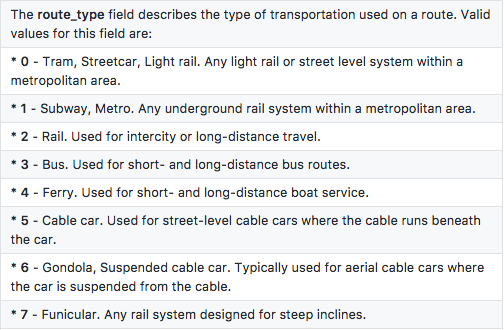

In [6]:
from IPython.display import Image
Image("http://i.imgur.com/Z9FPIdI.png")

These functions get all stop lats and lons for a particular operator.

In [7]:
def get_stop_lats(operator_onestop_id):
    stops_url = "http://transit.land/api/v1/stops?served_by={}&per_page=1000&api_key={}".format(operator_onestop_id, mapzen_api_key)
    lookup_stop_lats = {i['onestop_id']: i['geometry']['coordinates'][1] for i in transitland_request(stops_url)}
    return lookup_stop_lats

In [8]:
def get_stop_lons(operator_onestop_id):
    stops_url = "http://transit.land/api/v1/stops?served_by={}&per_page=1000&api_key={}".format(operator_onestop_id, mapzen_api_key)
    lookup_stop_lons = {i['onestop_id']: i['geometry']['coordinates'][0] for i in transitland_request(stops_url)}
    return lookup_stop_lons

This function gets origin-destination pairs and timestamps from the schedule stop pairs API. This is the most important function and the largest API request. 

In [9]:
def get_schedule_stop_pairs(operator_onestop_id, date):
    schedule_stop_pairs_url = "http://transit.land/api/v1/schedule_stop_pairs?date={}&operator_onestop_id={}&per_page=1000&api_key={}".format(date, operator_onestop_id, mapzen_api_key)    
    print schedule_stop_pairs_url
    origin_times = []
    destination_times = []
    origin_stops = []
    destination_stops = []
    route_ids = []
    count=0
    for i in transitland_request(schedule_stop_pairs_url):
        count+=1
        if count % 10000 == 0:
            print count
        origin_times.append(i['origin_departure_time'])
        destination_times.append(i['destination_arrival_time'])
        origin_stops.append(i['origin_onestop_id'])
        destination_stops.append(i['destination_onestop_id'])
        route_ids.append(i['route_onestop_id'])
        
    return origin_times, destination_times, origin_stops, destination_stops, route_ids

This function calculates durations between origin and destination pairs (in seconds).

In [10]:
def calculate_durations(origin_times, destination_times):
    origin_since_epoch = [int(i.split(':')[0])*60*60 + int(i.split(':')[1])*60 + int(i.split(':')[2]) for i in origin_times]
    destination_since_epoch = [int(i.split(':')[0])*60*60 + int(i.split(':')[1])*60 + int(i.split(':')[2]) for i in destination_times]
    durations = [b - a for a, b in zip(origin_since_epoch, destination_since_epoch)]
    return durations

This function cleans origin and destination times. This is a bit tricky because operators will often include non-real times such as "26:00:00" to indicate 2am the next day.

In [11]:
def clean_times(origin_times, destination_times):
    # Modulo away the > 24 hours
    origin_times_clean = [":".join([str(int(i.split(':')[0]) % 24), i.split(':')[1], i.split(':')[2]]) for i in origin_times]
    destination_times_clean = [":".join([str(int(i.split(':')[0]) % 24), i.split(':')[1], i.split(':')[2]]) for i in destination_times]
    return origin_times_clean, destination_times_clean

This function appends destination and origin dates to times, so that times become datetimes.

In [12]:
def add_dates(date, origin_times_clean, destination_times_clean):
    
    date1 = dt.datetime.strptime(date, "%Y-%m-%d").date()
    date2 = date1 + dt.timedelta(days=1)
    
    origin_datetimes = []
    destination_datetimes = []
    
    for i in range(len(origin_times_clean)):
        if int(destination_times_clean[i].split(":")[0]) < int(origin_times_clean[i].split(":")[0]):
            origin_datetime = str(date1) + " " + origin_times_clean[i]
            destination_datetime = str(date2) + " " + destination_times_clean[i]
        else:
            origin_datetime = str(date1) + " " + origin_times_clean[i]
            destination_datetime = str(date1) + " " + destination_times_clean[i]
          
        origin_datetimes.append(origin_datetime)
        destination_datetimes.append(destination_datetime)
    
    return origin_datetimes, destination_datetimes

This function generates the output table, to be saved later as a csv.

In [13]:
def generate_output(operator_onestop_id, origin_datetimes, destination_datetimes, durations, origin_stops, destination_stops, route_ids, lookup_stop_lats, lookup_stop_lons, lookup_vehicle_types):
    
    origin_stop_lats = [lookup_stop_lats[i] for i in origin_stops]
    origin_stop_lons = [lookup_stop_lons[i] for i in origin_stops]
    destination_stop_lats = [lookup_stop_lats[i] for i in destination_stops]
    destination_stop_lons = [lookup_stop_lons[i] for i in destination_stops]
    vehicle_types = []
    for i in route_ids:
        try:
            vehicle_type = lookup_vehicle_types[i]
            vehicle_types.append(vehicle_type)
        except:
            vehicle_types.append("NA")
    
    output = pd.DataFrame({
        'route_type': vehicle_types,
        'start_time': origin_datetimes,
        'start_lat': origin_stop_lats,
        'start_lon': origin_stop_lons,
        'end_time': destination_datetimes,
        'end_lat': destination_stop_lats,
        'end_lon': destination_stop_lons,
        'duration': durations
    })
    output = output[['start_time', 'start_lat', 'start_lon', 'end_time', 'end_lat', 'end_lon', 'duration', 'route_type']]
    
    return output

This is the main function that ties all of the above together!

In [14]:
def animate_one_day(operator_onestop_id, date):
    
    lookup_vehicle_types = get_vehicle_types(operator_onestop_id)
    lookup_stop_lats = get_stop_lats(operator_onestop_id)
    lookup_stop_lons = get_stop_lons(operator_onestop_id)
    origin_times, destination_times, origin_stops, destination_stops, route_ids = get_schedule_stop_pairs(operator_onestop_id, date)
    durations = calculate_durations(origin_times, destination_times)
    origin_times_clean, destination_times_clean = clean_times(origin_times, destination_times)
    origin_datetimes, destination_datetimes = add_dates(date, origin_times_clean, destination_times_clean)
    output = generate_output(operator_onestop_id, origin_datetimes, destination_datetimes, durations, origin_stops, destination_stops, route_ids, lookup_stop_lats, lookup_stop_lons, lookup_vehicle_types)
    output['start_time'] = pd.to_datetime(output['start_time'])
    output['end_time'] = pd.to_datetime(output['end_time'])
    output = output.sort_values(by=['start_time', 'end_time']).reset_index(drop=True)
    
    return output

### With those helper functions defined, let's get the LIRR data

### Run script on LIRR and save results to a csv

In [15]:
output = animate_one_day(operator_onestop_id, date)

http://transit.land/api/v1/schedule_stop_pairs?date=2017-07-17&operator_onestop_id=o-dr5-longislandrailroad&per_page=1000&api_key=mapzen-ai1duha


In [16]:
print output.shape[0], "rows."

7936 rows.


In [17]:
output.to_csv("data/{}.csv".format(directory))

### That's it for the trip data!

Now you can open Processing and click `play` to view the animation.